<a href="https://colab.research.google.com/github/nikhilpavithran/Practical-Deep-Learning-Book/blob/master/Anam_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!gdown --id 1TE6dok2KCbAzg-RHiDXn0W5hN9ichYX_
!gdown --id 1qmD5315SYiVCh-Ya5rTOhxoMpTVJd7u6
!gdown --id 1Ddtjl0db_zWgDQ48lRw7JSkTljITyJWe

Downloading...
From: https://drive.google.com/uc?id=1TE6dok2KCbAzg-RHiDXn0W5hN9ichYX_
To: /content/AnamNet_117_model.pth
18.6MB [00:00, 70.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qmD5315SYiVCh-Ya5rTOhxoMpTVJd7u6
To: /content/test_image.npy
3.04MB [00:00, 95.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ddtjl0db_zWgDQ48lRw7JSkTljITyJWe
To: /content/test_label.npy
2.62MB [00:00, 80.3MB/s]


In [3]:
!gdown --id 1swHLI0qJN2GNzKMQixxz35RHkgFQlIor

Downloading...
From: https://drive.google.com/uc?id=1swHLI0qJN2GNzKMQixxz35RHkgFQlIor
To: /content/sampledata.mat
100% 185k/185k [00:00<00:00, 63.6MB/s]


In [4]:
!ls -lrt
!pwd

def shImg(image, txt):
  plt.imshow(image, cmap="gray", origin="lower")
  plt.title(txt, fontweight ="bold") 
  plt.show()   

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")  

total 23896
drwxr-xr-x 1 root root     4096 Feb  4 15:26 sample_data
-rw-r--r-- 1 root root 18613269 Feb  6 08:22 AnamNet_117_model.pth
-rw-r--r-- 1 root root  3039062 Feb  6 08:22 test_image.npy
-rw-r--r-- 1 root root  2621440 Feb  6 08:22 test_label.npy
-rw-r--r-- 1 root root   184752 Feb  6 08:22 sampledata.mat
/content


1 (512, 512)
2 (512, 512, 1)
Unique inp_1 {0: 1, 6: 3, 7: 2, 8: 4, 10: 5, 11: 5, 12: 2, 13: 5, 15: 9, 16: 15, 17: 22, 18: 30, 19: 46, 21: 51, 22: 64, 23: 88, 24: 93, 25: 118, 27: 138, 28: 197, 29: 236, 30: 238, 32: 284, 33: 334, 34: 365, 35: 476, 36: 469, 38: 530, 39: 572, 40: 644, 41: 708, 43: 763, 44: 741, 45: 778, 46: 856, 47: 860, 49: 914, 50: 923, 51: 929, 52: 957, 53: 912, 55: 944, 56: 923, 57: 900, 58: 889, 60: 854, 61: 817, 62: 761, 63: 768, 64: 734, 66: 646, 67: 672, 68: 611, 69: 573, 70: 598, 72: 525, 73: 436, 74: 422, 75: 411, 77: 412, 78: 332, 79: 327, 80: 310, 81: 333, 83: 303, 84: 286, 85: 283, 86: 305, 87: 274, 89: 282, 90: 251, 91: 221, 92: 234, 94: 247, 95: 196, 96: 217, 97: 226, 98: 216, 100: 211, 101: 215, 102: 202, 103: 217, 104: 183, 106: 186, 107: 200, 108: 199, 109: 187, 111: 161, 112: 192, 113: 190, 114: 191, 115: 189, 117: 177, 118: 177, 119: 174, 120: 172, 121: 162, 123: 192, 124: 173, 125: 154, 126: 176, 128: 182, 129: 170, 130: 186, 131: 161, 132: 176, 134: 

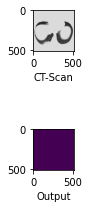

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io as io
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

class Bottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding =1,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())


        self.ext_conv2 = nn.Sequential(
             nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
                dilation=dilation,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)
        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x
        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)
        # Add main and extension branches
        out = main + ext
        return self.out_activation(out)

class AnamNet(nn.Module):

    def __init__(self):

        super(AnamNet, self).__init__()

        # Conv block 1 - Down 1
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 1
        self.bottleneck1 = Bottleneck(64)


        # Conv block 2 - Down 2
        self.conv2_block = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 2
        self.bottleneck2 = Bottleneck(128)

        # Conv block 3 - Down 3
        self.conv3_block = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BottleNeck 3
        self.bottleneck3 = Bottleneck(256)

        # Conv block 4 - Down 4
        self.conv4_block = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Up 1
        self.up_1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)

        self.bottleneck4 = Bottleneck(256)
        # Up Conv block 1
        self.conv_up_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Up 2
        self.up_2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        
        self.bottleneck5 =Bottleneck(256)    
        # Up Conv block 2
        self.conv_up_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Up 3
        self.up_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

        self.bottleneck6 = Bottleneck(128)
        # Up Conv block 3
        self.conv_up_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # Up 4
        self.up_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        # Up Conv block 4
        self.conv_up_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Final output
        self.conv_final = nn.Conv2d(in_channels=64, out_channels=3,
                                    kernel_size=1, padding=0, stride=1)

    def forward(self, x):
        
        print('inputTensor', x.shape)
        print('inputTensor Type', x.type())
        #---------------------------------------------------------------------
        # Down 1
        x = self.conv1_block(x)
        #print('after conv1', x.shape)
        conv1_out = x  # Save out1
        conv1_dim = x.shape[2]
        x = self.max1(x)
        #print('after pool1', x.shape)
        #--------------------------------------------------------------------
        x = self.bottleneck1(x)
        #print('after bnck1', x.shape)
        # Down 2
        x = self.conv2_block(x)
        #print('after conv2', x.shape)
        conv2_out = x
        conv2_dim = x.shape[2]
        x = self.max2(x)
        #print('after pool2', x.shape)
        #-------------------------------------------------------------------
        x = self.bottleneck2(x)
        #print('after bnck2', x.shape)
        # Down 3
        x = self.conv3_block(x)
        #print('after conv3', x.shape)
        conv3_out = x
        conv3_dim = x.shape[2]
        x = self.max3(x)
        #print('after pool3', x.shape)
        #------------------------------------------------------------------
        x = self.bottleneck3(x)
        #print('after bnck3', x.shape)
        # Down 4
        x = self.conv4_block(x)
        #print('after conv4', x.shape)
        conv4_out = x
        conv4_dim = x.shape[2]
        x = self.max4(x)
        #print('after pool4', x.shape)
        #----------------------------------------------------------------        
        # Up 1
        x = self.up_1(x)
        #print('after  up_1', x.shape)
        x = self.bottleneck4(x)
        #print('after bnck4', x.shape)
        lower = int((conv4_dim - x.shape[2]) / 2)
        upper = int(conv4_dim - lower)
        conv4_out_modified = conv4_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv4_out_modified], dim=1)
        #print('after cat_1',x.shape)        
        x = self.conv_up_1(x)
        #print('after conv1', x.shape)
        #-----------------------------------------------------------------
        # Up 2
        x = self.up_2(x)
        #print('after  up_2', x.shape)
        x = self.bottleneck5(x)
        #print('after bnck5', x.shape)
        lower = int((conv3_dim - x.shape[2]) / 2)
        upper = int(conv3_dim - lower)
        conv3_out_modified = conv3_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv3_out_modified], dim=1)
        #print('after cat_2', x.shape)
        x = self.conv_up_2(x)
        #print('after conv2', x.shape)
        #----------------------------------------------------------------
        # Up 3
        x = self.up_3(x)
        #print('after  up_3', x.shape)
        x = self.bottleneck6(x)
        #print('after bnck6', x.shape)
        lower = int((conv2_dim - x.shape[2]) / 2)
        upper = int(conv2_dim - lower)
        conv2_out_modified = conv2_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv2_out_modified], dim=1)
        #print('after cat_3', x.shape)
        x = self.conv_up_3(x)
        #print('after conv3', x.shape)
        #----------------------------------------------------------------
        # Up 4
        x = self.up_4(x)
        #print('after  up_3', x.shape)
        lower = int((conv1_dim - x.shape[2]) / 2)
        upper = int(conv1_dim - lower)
        conv1_out_modified = conv1_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv1_out_modified], dim=1)
        #print('after cat_4', x.shape)
        x = self.conv_up_4(x)
        #print('after conv4', x.shape)
        # Final output
        x = self.conv_final(x)
        #print('Finaloutshape',x.shape)
        #-----------------------------------------------------------------
        return x
  
#if __name__ == "__main__":
#    x= torch.rand(1,1,512,512)
#    print('In Type :', x.type())
#    net=AnamNet()
#    yy=net(x)
#    print('In Shape :', x.shape)
#    print('Out Shape :', yy.shape)

if __name__=="__main__" :

    net = AnamNet()
    data = io.loadmat('sampledata.mat')

    net.load_state_dict(torch.load('AnamNet_117_model.pth',map_location=torch.device('cpu'))) #model.pth
    net.eval()

    fig, ax = plt.subplots()
    inp1 = data['im1']

    print("1", inp1.shape)

    plt.subplot(2,7,1)
    plt.imshow(inp1,cmap='gray', vmin=0, vmax=255)    
    #plt.axis('off')
    plt.xlabel('CT-Scan')
    inp1 = np.reshape(inp1,(512,512,1))
    print("2", inp1.shape)
   
    unique, counts = np.unique(inp1, return_counts=True)
    print("Unique inp_1",dict(zip(unique, counts)))

    inp1 = transforms.ToTensor()(inp1).unsqueeze(dim=0)

    unique, counts = np.unique(inp1, return_counts=True)
    print("Unique inp_1",dict(zip(unique, counts)))

    out1 = net(inp1)
    plt.subplot(2,7,8)
    out1 = out1.detach();

    #https://stackoverflow.com/questions/41203137/how-do-you-reduce-the-dimension-of-a-numpy-array
    out1 = np.squeeze(out1, axis=0)
    print("out1 after squeeze", out1.shape)

    pred = torch.argmax(out1, dim=0)
    print("pred shape", pred.shape)

    unique, counts = np.unique(pred, return_counts=True)
    print("pred",dict(zip(unique, counts)))

    plt.imshow(pred.numpy())   
    plt.xlabel('Output') 
    #plt.axis('off')
    plt.show()      

# https://www.analyticsvidhya.com/blog/2019/01/guide-pytorch-neural-networks-case-studies/
# https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/
# https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
# https://towardsdatascience.com/convolution-neural-network-for-image-processing-using-keras-dc3429056306
# How to visualize segmentation output - multiclass feature map to rgb image? 
# https://discuss.pytorch.org/t/how-to-visualize-segmentation-output-multiclass-feature-map-to-rgb-image/26986/2
# colorize an output class labels of a segmentation in pytorch
# https://github.com/dusty-nv/pytorch-segmentation/blob/master/datasets/deepscene_remap.py
# https://towardsdatascience.com/semantic-hand-segmentation-using-pytorch-3e7a0a0386fa

inp1.shape  :  (512, 512, 5)
lab1.shape  :  (512, 512, 5)


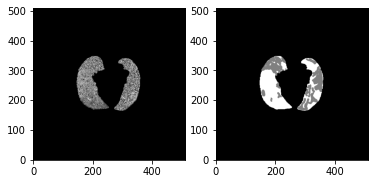

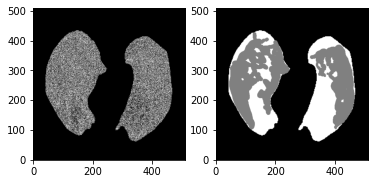

In [7]:
data_arr_im = np.loadtxt("test_image.npy",dtype=int)
im_inp1 = data_arr_im.reshape(data_arr_im.shape[0], data_arr_im.shape[1] // 5, 5) 

data_arr_lab = np.loadtxt("test_label.npy",dtype=int)
im_lab1 = data_arr_lab.reshape(data_arr_lab.shape[0], data_arr_lab.shape[1] // 5, 5) 

print("inp1.shape  : ", im_inp1.shape)
print("lab1.shape  : ", im_lab1.shape)

inp_1 = im_inp1[:,:,0]
lab_1 = im_lab1[:,:,0]

inp_2 = im_inp1[:,:,1]
lab_2 = im_lab1[:,:,1]

show_slices([inp_1, lab_1])
show_slices([inp_2, lab_2])

In [9]:
net = AnamNet()
#data = io.loadmat('sampledata.mat')

net.load_state_dict(torch.load('AnamNet_117_model.pth',map_location=torch.device('cpu'))) #cpu existing
net.eval()

#fig, ax = plt.subplots()
#inp1 = data['im1']

inp1 = im_inp1[:,:,0]
lab1 = im_lab1[:,:,0]

print("1", inp1.shape)
inp1 = np.reshape(inp1,(512,512,1)) # https://stackoverflow.com/questions/14476415/reshape-an-array-in-numpy/14476457#14476457 https://deeplizard.com/learn/video/fCVuiW9AFzY
print("2",inp1.shape)

unique, counts = np.unique(inp1, return_counts=True)
print("Unique inp_1",dict(zip(unique, counts)))

#inp1 = inp1.unsqueeze(dim=0)
#print(inp1.shape)

inp1 = inp1.astype(float)
inp1 = transforms.ToTensor()(inp1).unsqueeze(dim=0) #https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch [Adds a new diamension at 0]
print("3",inp1.type())
#inp1 = torch.long(inp1)

unique, counts = np.unique(inp1, return_counts=True)
print("Unique inp_1",dict(zip(unique, counts)))

print("4",inp1.shape)

out1 = net(inp1) #https://stackoverflow.com/questions/63383347/runtimeerror-expected-object-of-scalar-type-long-but-got-scalar-type-float-for

#print(out1.shape)

#lab_out = out1.numpy()
#show_slices([inp1, lab1])
#show_slices([inp1, lab_out])

1 (512, 512)
2 (512, 512, 1)
3 torch.DoubleTensor
Unique inp_1 {0.0: 242594, 2.0: 161, 4.0: 105, 6.0: 70, 8.0: 199, 10.0: 100, 12.0: 94, 14.0: 143, 16.0: 95, 18.0: 106, 20.0: 168, 22.0: 78, 24.0: 109, 26.0: 153, 28.0: 87, 30.0: 108, 32.0: 172, 34.0: 90, 36.0: 113, 38.0: 140, 40.0: 91, 42.0: 121, 44.0: 135, 46.0: 95, 48.0: 159, 50.0: 151, 52.0: 77, 54.0: 177, 56.0: 130, 58.0: 86, 60.0: 185, 62.0: 152, 64.0: 63, 66.0: 206, 68.0: 129, 70.0: 89, 72.0: 227, 74.0: 121, 76.0: 81, 78.0: 303, 80.0: 132, 82.0: 90, 84.0: 328, 86.0: 112, 88.0: 81, 90.0: 319, 92.0: 103, 94.0: 72, 96.0: 369, 98.0: 122, 100.0: 87, 102.0: 343, 104.0: 90, 106.0: 76, 108.0: 423, 110.0: 105, 112.0: 74, 114.0: 408, 116.0: 101, 118.0: 93, 120.0: 406, 122.0: 84, 124.0: 81, 126.0: 447, 128.0: 114, 130.0: 109, 132.0: 430, 134.0: 111, 136.0: 80, 138.0: 444, 140.0: 79, 142.0: 85, 144.0: 420, 146.0: 91, 148.0: 79, 150.0: 414, 152.0: 104, 154.0: 92, 156.0: 359, 158.0: 84, 160.0: 80, 162.0: 369, 164.0: 77, 166.0: 80, 168.0: 337, 1

RuntimeError: ignored

In [ ]:
net = AnamNet()
#data = io.loadmat('sampledata.mat')

net.load_state_dict(torch.load('AnamNet_117_model.pth',map_location=torch.device('cpu')))
net.eval()

fig, ax = plt.subplots()
inp1 = data['im1']
    plt.subplot(2,7,1)
    plt.imshow(inp1,cmap='gray', vmin=0, vmax=255)    
    #plt.axis('off')
    plt.xlabel('CT-Scan')
    inp1 = np.reshape(inp1,(512,512,1))
    inp1 = transforms.ToTensor()(inp1).unsqueeze(dim=0)
    out1 = net(inp1)
    plt.subplot(2,7,8)
    plt.imshow(out1.numpy())   
    plt.xlabel('Output') 
    #plt.axis('off')
    #plt.show() 

    inp2 = data['im2']
    plt.subplot(2,7,3)
    plt.imshow(inp2,cmap='gray', vmin=0, vmax=255)    
    plt.xlabel('CT-Scan')
    #plt.axis('off')
    plt.xlabel('CT-Scan')
    inp2 = np.reshape(inp2,(512,512,1))
    inp2 = transforms.ToTensor()(inp2).unsqueeze(dim=0)
    out2 = net(inp2)
    plt.subplot(2,7,10)
    plt.imshow(out2.numpy())    
    plt.xlabel('Output')
    #plt.axis('off')
    #plt.show() 

    inp3 = data['im3']
    plt.subplot(2,7,5)
    plt.imshow(inp3,cmap='gray', vmin=0, vmax=255)    
    #plt.axis('off')
    plt.xlabel('CT-Scan')
    inp3 = np.reshape(inp3,(512,512,1))
    inp3 = transforms.ToTensor()(inp3).unsqueeze(dim=0)
    out3 = net(inp3)
    plt.subplot(2,7,12)
    plt.imshow(out3.numpy())  
    plt.xlabel('Output')  
    #plt.axis('off')
    #plt.show() 

    inp4 = data['im4']
    plt.subplot(2,7,7)
    plt.imshow(inp4,cmap='gray', vmin=0, vmax=255)    
    #plt.axis('off')
    plt.xlabel('CT-Scan')
    inp4 = np.reshape(inp4,(512,512,1))
    inp4 = transforms.ToTensor()(inp4).unsqueeze(dim=0)
    out4 = net(inp4)
    plt.subplot(2,7,14)
    plt.imshow(out4.numpy())
    plt.xlabel('Output')
    #plt.axis('off')
    plt.show() 

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 512, 512, 1] to have 1 channels, but got 512 channels instead site:stackoverflow.com